In [ ]:
# Software Name : DistFactAssessLM
# SPDX-FileCopyrightText: Copyright (c) 2025 Orange SA
# SPDX-License-Identifier: GPL-2.0-or-later

# This software is distributed under the GNU General Public License v2.0 or later,
# see the "LICENSE.txt" file for more details or GNU General Public License v2.0 or later

# Authors: Hichem Ammar Khodja
# Software description: A factual knowledge assessment method for large language models using distractors

In [ ]:
%cd ../../src

import os
import os.path as osp
from globals import STORAGE_FOLDER
import pickle
import pandas as pd
from know.core import DistKnowMeasureReturn
import seaborn as sns
import matplotlib.pyplot as plt

# To choose what results to analyze
TEMPORAL_DISTRACTOR_RESULT_ANALYSIS = False

if TEMPORAL_DISTRACTOR_RESULT_ANALYSIS:
    # Compare all strategies on random sample of facts
    data_folder = osp.join(STORAGE_FOLDER, 'compare_retrieval_strategies_results__facts_balanced_5000_temp_dist')
else:
    # To compare between IDF and Temp-IDF on 1000 facts that have atleast one temporal distractor each. 
    data_folder = osp.join(STORAGE_FOLDER, 'compare_retrieval_strategies_results__facts_balanced_5000')

/workspace/src


/opt/conda/envs/wfd_build/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [48]:
config2data = {}
for filename in os.listdir(data_folder):
    print(filename)
    data = pickle.load(open(osp.join(data_folder, filename), 'rb'))
    model_name, strategy = osp.splitext(filename)[0].split('__')
    config2data[(model_name, strategy)] = data

EleutherAI_pythia-6.9b__temp_idf.pkl


EleutherAI_pythia-6.9b__AoID.pkl
EleutherAI_pythia-6.9b__random.pkl
EleutherAI_pythia-6.9b__idf.pkl


In [54]:
import numpy as np
from know.core import WeightMetric


aggcls2name = {
    'know.core.MeanMetric' : "Avg@$n$",
    'know.core.StrictMetric': "Min@$n$"
}
strategy2name = {
    'idf' : 'Sem',
    'temp_idf' : 'Temp+Sem',
    'AoID' : 'ApprOpt',
    'random' : 'Random',
    'pure_random' : "Random w/o type"
}

def correct_model_name(model_name : str) -> str:
    if model_name == 'random':
        return 'RandomLM'
    model_name = model_name[len('EleutherAI_'):]
    model_name = model_name[0].upper() + model_name[1:-1] + model_name[-1].upper()
    return model_name

def plot_vs_strategies_1model(model_name : str):
    strategy2data = {(mn, strategy):v for (mn, strategy),v in config2data.items() if model_name in [mn, 'random']}
    model_name = correct_model_name(model_name)
    df = []
    columns = ['Model', 'Strategy', 'n', 'know_measure', 'agg', 'Triple']
    for (mn, strategy), data in strategy2data.items():
        mn = correct_model_name(mn)
        strategy = strategy2name[strategy]
        for measure in data:
            measure : DistKnowMeasureReturn
            agg_name = aggcls2name[measure.know_measure_info['agg']['cls']]
            res = np.array(measure.result, dtype=np.float32)
            # res[np.isnan(res)] = np.nanmax(res)
            for n, value in zip(measure.know_measure_info['agg']['n'], res):
                df.append((mn, strategy, n, value, agg_name, measure.temp.triple))
        else:
            # Pos@n compute
            for measure in data:
                measure : DistKnowMeasureReturn
                agg_name = 'Pos@n'
                res = np.array(measure.result, dtype=np.float32)
                # res[np.isnan(res)] = np.nanmax(res)
                for n, value, cred_dist in zip(measure.know_measure_info['agg']['n'], res, measure.cred_dist):
                    df.append((mn, strategy, n, float(cred_dist < measure.cred_true), agg_name, measure.temp.triple))
    
    df = pd.DataFrame(df, columns=columns)
    df = df[~df['know_measure'].isna()]

    # plt.rcParams.update({'font.size': 16})
    plt.rcParams.update({'font.size': 13})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are embedded as Type 42 (TrueType)
    sns.set_style("whitegrid", {'grid.linestyle': '--'})
    default_palette = sns.color_palette()

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    if not isinstance(axs, (list, tuple)):
        axs = [axs]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0)
    for i, c in enumerate(('Min@$n$',)):
        data_ = df[(df['agg'] == c) & (df['Strategy'] != "Random w/o type")]
        
        sns.lineplot(x='n', y='know_measure', data=data_, ax=axs[i], hue='Strategy', hue_order=["Random", "Sem", 'Temp+Sem', 'ApprOpt'], 
                    #  palette=[default_palette[0]] + default_palette[2:4]
                     )
        axs[i].set_ylim((0,1))
        axs[i].set_ylabel('Mean %s over $S\'$' % c)
        if i in (0,1):
            # Adjust ylim
            axs[i].set_ylim((0.1,0.85))
        axs[i].set_xticks([1,20,40,60,80,100])
        axs[i].set_xlabel('Number of distractors')
        if i != 0:
            l = axs[i].get_legend()
            if l:
                l.remove()
        else:
            # axs[i].legend(bbox_to_anchor=(1, 1))
            pass
            # sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
    fn = 'plot_vs_strategies_1model__%s_temp.pdf' % model_name
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)
    fig.show()
    return df

def plot_vs_models_1strategy(strategy_names : str):
    strategy2data = {(mn, strategy):v for (mn, strategy),v in config2data.items() if strategy in strategy_names and mn != 'random'}
    df = []
    columns = ['Model', 'n', 'know_measure', 'agg', 'Retriever']
    for (mn, strategy), data in strategy2data.items():
        strategy = strategy2name[strategy]
        model_name = correct_model_name(mn)
        for measure in data:
            measure : DistKnowMeasureReturn
            agg_name = aggcls2name[measure.know_measure_info['agg']['cls']]
            res = np.array(measure.result, dtype=np.float32)
            # res[np.isnan(res)] = np.nanmax(res)
            for n, value in zip(measure.know_measure_info['agg']['n'], res):
                df.append((model_name, n, value, agg_name, strategy))
        else:
            # Pos@n compute
            for measure in data:
                measure : DistKnowMeasureReturn
                agg_name = 'Pos@n'
                res = np.array(measure.result, dtype=np.float32)
                # res[np.isnan(res)] = np.nanmax(res)
                for n, value, cred_dist in zip(measure.know_measure_info['agg']['n'], res, measure.cred_dist):
                    df.append((model_name, n, float(cred_dist < measure.cred_true), agg_name, strategy))
                
                # met = WeightMetric(np.arange(101))
                # res = np.array(met.compute(measure.cred_true, measure.cred_dist), dtype=np.float32)
                # # res[np.isnan(res)] = np.nanmax(res)
                # for n, value in zip(met.n, res):
                #     df.append((model_name, n, value, "Prob@$n$", strategy))
    
    df = pd.DataFrame(df, columns=columns)
    df = df[~df['know_measure'].isna()]
    df['Pythia'] = df['Model'].apply(lambda x : x[len('Pythia-'):])

    plt.rcParams.update({'font.size': 13})
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are embedded as Type 42 (TrueType)
    sns.set_style("whitegrid", {'grid.linestyle': '--'})
    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    if not isinstance(axs, (list, tuple)):
        axs = [axs]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0)
    for i, c in enumerate(('Avg@$n$',)):
        data_ = df[(df['agg'] == c)]
        
        sns.lineplot(x='n', y='know_measure', data=data_, ax=axs[i], hue='Pythia', hue_order=['70M', '410M', "2.8B", "6.9B", "12B"], errorbar=None)
        axs[i].set_ylim((0.3,0.9))
        axs[i].set_ylabel(c)
        if i in (1,2):
            # Adjust ylim
            axs[i].set_ylim((0.4,1))
        axs[i].set_xticks([1,20,40,60,80,100])
        axs[i].set_xlabel('Number of distractors')
        axs[i].set_ylabel('Mean %s over $S$' % c)
        # axs[i].legend(bbox_to_anchor=(1, 1.05))
        # sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))
    fn = 'plot_vs_models_1strategy__%s.pdf' % '_'.join(strategy_names)
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)
    fig.show()
    return df

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

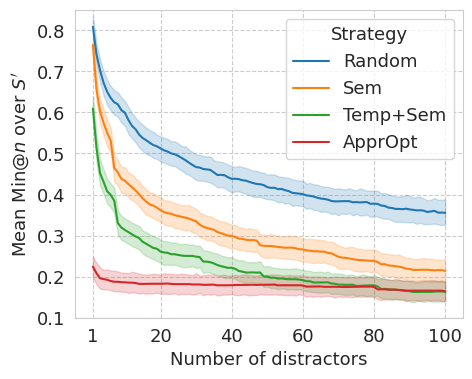

In [55]:
df = plot_vs_strategies_1model('EleutherAI_pythia-6.9b')

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


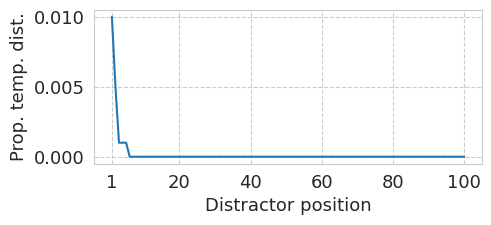

In [44]:
a = np.array([np.array([neigh.is_temp for neigh in res.neighbors] + [None]*(100-len(res.neighbors))) for res in config2data[('EleutherAI_pythia-6.9b', 'temp_idf')]], dtype=np.float32)
plt.figure(figsize=(5,2))
sns.lineplot(y=np.nanmean(a, axis=0), x=np.arange(1,101))
plt.xticks([1] + list(range(20,101,20)));
plt.xlabel('Distractor position')
plt.ylabel('Prop. temp. dist.')
plt.savefig("distpos_tempdist.pdf", bbox_inches='tight', pad_inches=0)

/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/wfd_build/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a le

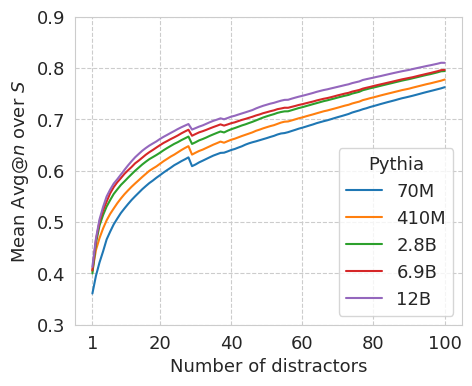

In [17]:
df = plot_vs_models_1strategy(['AoID'])

In [13]:
df['Model'].unique()

array(['Pythia-2.8B', 'Pythia-6.9B', 'Pythia-410M', 'Pythia-12B',
       'Pythia-70M'], dtype=object)

In [14]:
powers = {
    'B' : 10**9,
    'M' : 10**6
}
df['Pythia'] = df['Pythia'].apply(lambda x : float(x[:-1]) * powers[x[-1]])


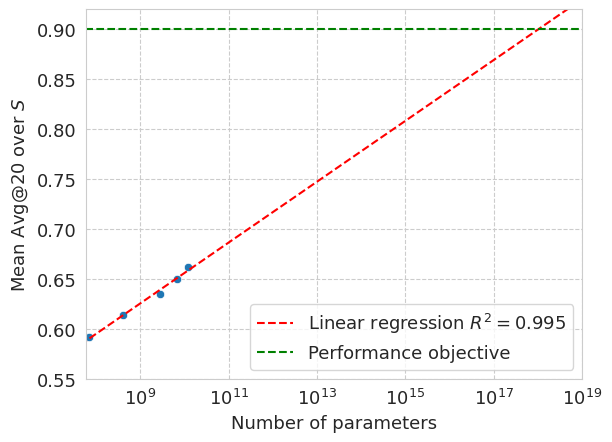

In [18]:
# Extrapolating the log-linear trend


size2rob = df[(df['n'] == 20) & (df['agg'] == 'Avg@$n$')].groupby('Pythia')['know_measure'].mean()

from scipy.stats import linregress

res = linregress(np.log(size2rob.index), size2rob.values)
x = [x for x in np.geomspace(10**6, float(10**25), 1000)]
y = [np.log(x)*res.slope + res.intercept for x in x]

# size2rob.index = np.log(size2rob.index)
sns.scatterplot(size2rob)
regression = plt.plot(x,y, '--', color='red', label='Linear regression $R^2=%.3f$' % res.rvalue)
objective = plt.plot(x,[0.9 for x in x], '--', color='green', label='Performance objective')
plt.xscale('log')
plt.xlim((60*10**6, float(10**19)))
plt.ylim(0.55,0.92)
plt.xlabel('Number of parameters')
plt.ylabel('Mean Avg@$20$ over $S$')
plt.legend()
plt.savefig("extrapolation.pdf", bbox_inches='tight', pad_inches=0)
